In [2]:
import numpy as np                                             
import matplotlib as mtp                                        
import matplotlib.pyplot as plt                                 
import pandas as pd                                             
import geopandas as gpd                                         
import rasterio
from rasterstats import zonal_stats
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import os

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

# Data Cleaning and Munging

In [3]:
path= 'F:\CS6010_project\Maize_project'
os.chdir(path)

In [4]:
# reads the polygon for each plot
plots= gpd.read_file('plots.shp')


# reads the remote sensing data as an array
sentinel2_2020= rasterio.open('sentinel2_2020/RS_features.tif')
rapideye_2017= rasterio.open('rapideye_2017/RS_feature.tif')
RapSen= [sentinel2_2020.read(), rapideye_2017.read()]

# reads crop yield dat and other features
crop_2017= pd.read_csv('2017_yield.csv')
crop_2020= pd.read_csv('2020_yield.csv')

# Transforms pixel coordinates to x,y coordinaetes
affine= sentinel2_2020.transform

In [5]:
# column names
names= ['NIR_20', 'Red_Edge_20', 'Red_20', 'Green_20', 'Blue_20', 'NDVI_20', 'NDRE_20', 'NDWI_20', 'EVI_20', 'LAI_20', 
          'Blue_17', 'Green_17', 'Red_17', 'Red_Edge_17', 'NIR_17', 'NDVI_17', 'NDRE_17', 'NDWI_17', 'EVI_17', 'LAI_17']

new_names= ['Id', 'Name', 'geometry', 'Blue', 'Green', 'Red', 'Red_Edge', 'NIR', 'NDVI', 'NDRE', 'NDWI', 'EVI', 'LAI']


# calculates the median RS feature value of each plot
median= []
for each in RapSen:
    for band in each:
        df_median = pd.DataFrame(zonal_stats(plots, band, affine=affine, stats= 'median'))
        median.append(df_median)

median_df= pd.concat(median, axis=1)

# renames the columns and splits them based on the year
median_df= median_df.set_axis(names, axis=1)
median_2020= median_df.filter(like= '_20')
median_2017= median_df.filter(like= '_17')

# adds median statistics of each year to the plots GeoDataFrame
median_2020_plots = pd.concat([plots, median_2020], axis=1).iloc[:,[0, 1, 2, 7, 6, 5, 4, 3, 8, 9, 10, 11, 12]] # reorders the columns of 2020 data to match that of 2017
median_2017_plots = pd.concat([plots, median_2017], axis=1)

# renames the columns of both dataframes for concatenation
median_2020_plots.columns= new_names
median_2017_plots.columns= new_names

# normalize the spectral bands from sentinel2 and rapideye
median_2020_plots.iloc[:,[3, 4, 5, 6, 7]] = Normalizer().fit_transform(median_2020_plots.iloc[:,[3, 4, 5, 6, 7]].to_numpy())
median_2017_plots.iloc[:,[3, 4, 5, 6, 7]] = Normalizer().fit_transform(median_2017_plots.iloc[:,[3, 4, 5, 6, 7]].to_numpy())

# appends the VIs to the normalized spectral bands
#plots_2020= pd.concat([plots_2020, median_2020_plots.iloc[:, [1, 2, 8, 9, 10, 11, 12]]], axis= 1)
#plots_2017= pd.concat([plots_2017, median_2017_plots.iloc[:, [1, 2, 8, 9, 10, 11, 12]]], axis= 1)

# adds the crop yield data to the the RS features
plots_2020= median_2020_plots.merge(crop_2020, on= 'Name')
plots_2017= median_2017_plots.merge(crop_2017, on= 'Name')

C:\Users\user\anaconda3\envs\osgeo\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [6]:
# merges data of both years
gdf= pd.concat([plots_2020, plots_2017]).reset_index(drop=True).drop('Id', axis= 1)

In [6]:
gdf.head()

,Name,geometry,Blue,Green,Red,Red_Edge,NIR,NDVI,NDRE,NDWI,EVI,LAI,Yield,Treatment,Prp,Temp,RH,SR
0,T2R5,"POLYGON ((634092.234 4697157.568, 634158.210 4697157.125, 634157.648 4697073...",0.089414,0.156096,0.113788,0.228082,0.950089,0.787011,0.609199,-0.720811,2.191791,7.811900,162.2,T2,0.0,20.4,68.93,256.82
1,T3R5,"POLYGON ((634192.196 4697156.718, 634258.179 4697156.940, 634258.460 4697073...",0.067680,0.138888,0.076940,0.203041,0.963838,0.852703,0.650150,-0.748071,2.393842,8.542921,134.0,T3,0.0,20.4,68.93,256.82
2,T1R5,"POLYGON ((634002.183 4697036.651, 634067.312 4697036.871, 634067.597 4696952...",0.138950,0.221168,0.210630,0.329975,0.882343,0.613647,0.457211,-0.599108,1.488853,5.268669,94.2,T1,0.0,20.4,68.93,256.82
3,T4R5,"POLYGON ((634192.479 4697047.694, 634258.177 4697047.694, 634258.177 4696962...",0.109702,0.190628,0.153745,0.279794,0.921794,0.717647,0.531949,-0.654289,1.881873,6.690615,106.8,T4,0.0,20.4,68.93,256.82
4,T1R1,"POLYGON ((633913.265 4696916.866, 633978.400 4696916.646, 633978.113 4696831...",0.140317,0.222508,0.214486,0.325555,0.882503,0.611041,0.459759,-0.597185,1.512375,5.353773,70.4,T1,0.0,20.4,68.93,256.82


In [7]:
# prepares the independent and dependent variables
x = pd.get_dummies(gdf[['Blue', 'Green', 'Red', 'Red_Edge', 'NIR', 'NDVI', 'NDRE', 'NDWI', 'EVI', 'LAI', 'Treatment', 'Prp',
       'Temp', 'RH', 'SR']])
y = gdf["Yield"]

## Exploratory Data Analysis

Text(0.5, 1.0, '2017 Yield')

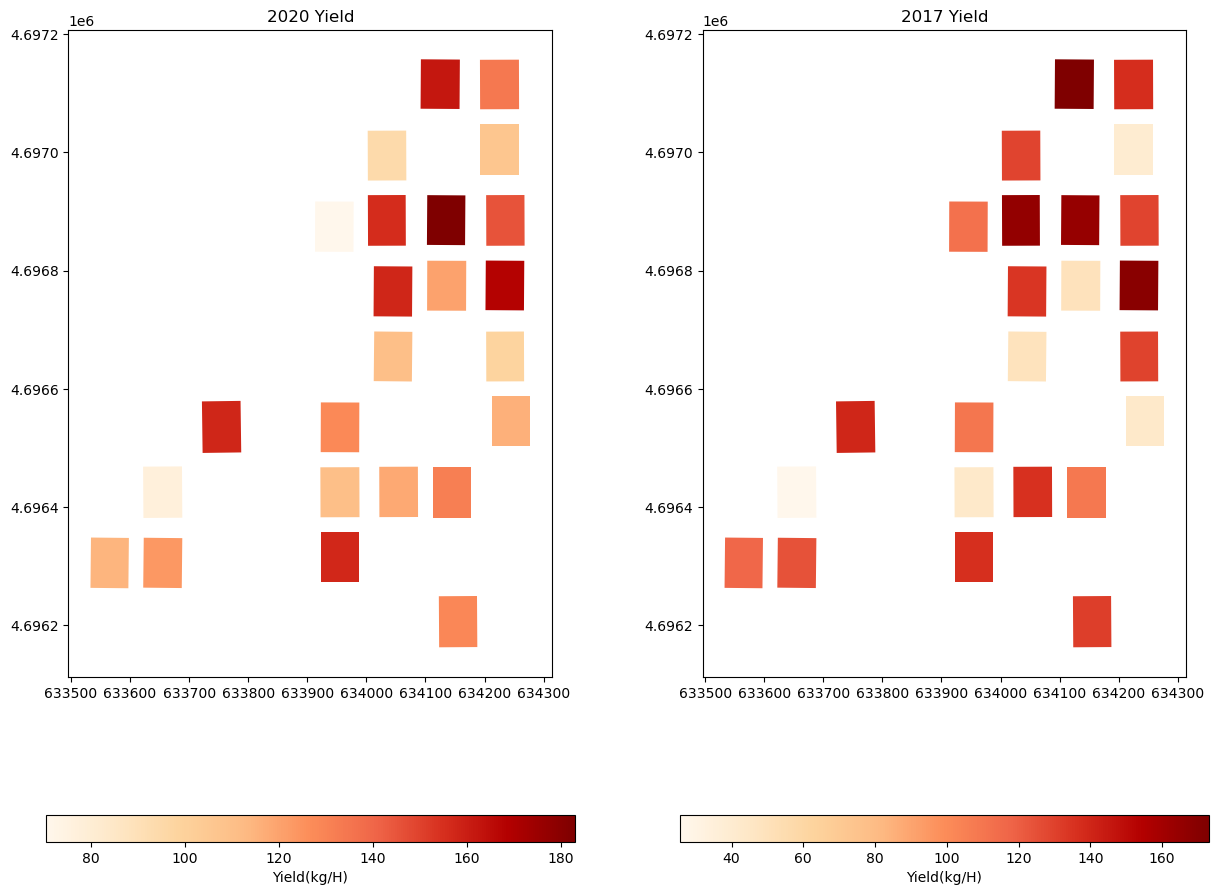

In [16]:
# splits data according to year
gdf_2020= gdf.iloc[0:24, :]
gdf_2017= gdf.iloc[24:, :]

# Creates 2 subplots
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(15, 12)) 
 
# Access each axes object to plot the data
gdf_2020.plot(column= 'Yield', ax= ax[0], legend= True, legend_kwds= {'label': 'Yield(kg/H)', 'orientation': 'horizontal'}, cmap='OrRd').set_title('2020 Yield')

gdf_2017.plot(column= 'Yield', ax= ax[1], legend= True, legend_kwds= {'label': 'Yield(kg/H)', 'orientation': 'horizontal'}, cmap='OrRd').set_title('2017 Yield')

<Axes: >

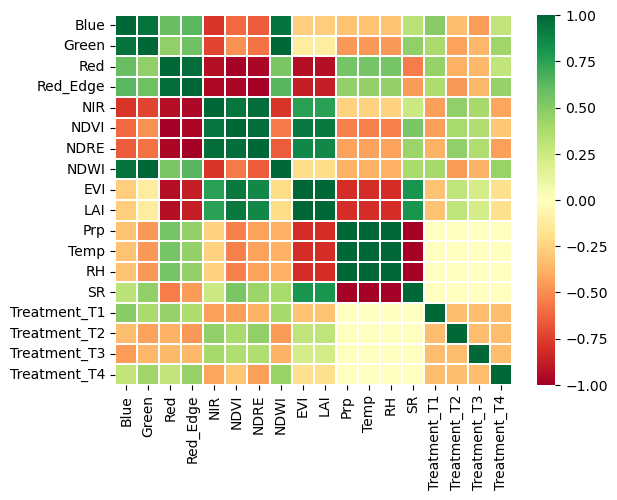

In [24]:
sns.heatmap(x.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = False)

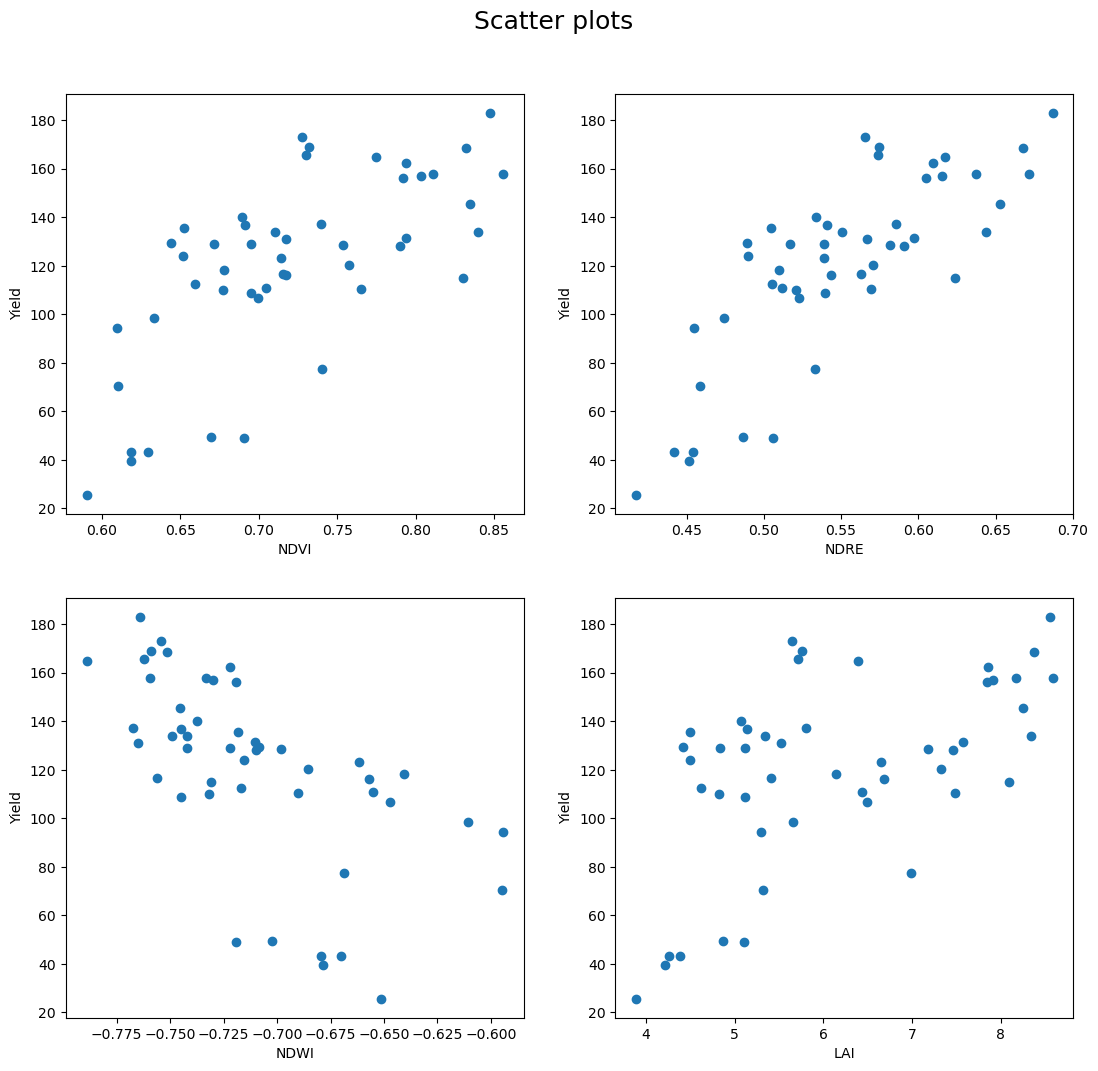

In [12]:
# selects features of interest for plotting
gdf_plots= gdf.iloc[:, [7, 8, 9, 11]]

# plots scatter plots of the independent variables with some of the dependent variable

# defines the subplots
fig, axs= plt.subplots(nrows=2, ncols=2, figsize= (13, 12))
fig.suptitle('Scatter plots', fontsize=18, y=0.95)

# loops through the variables and subplots
for variable, ax in zip(gdf_plots, axs.ravel()):
    ax.scatter(x= gdf_plots[variable], y= gdf['Yield'])
    
    ax.set_xlabel(variable)
    ax.set_ylabel('Yield')

## Modeling

In [8]:
kf = KFold(n_splits=5, shuffle= True, random_state= 42)

coefs = {}
scores = {} # R^2
RMSE = {} # Square root of Mean Squared Error
all_scores= []

# initiates model
rf= RandomForestRegressor(random_state=42)

In [13]:
lr = Ridge(random_state= 42)

# selects the best features
SFS2 = SFS(lr, 
           k_features= 'best', 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=kf)


SFS2 = SFS2.fit(x, y)

In [14]:
# prints the selected features from mlxtend
x.columns[list(SFS2.k_feature_idx_)]

Index(['Blue', 'Green', 'Red', 'Red_Edge', 'NIR', 'NDVI', 'NDRE', 'NDWI',
       'EVI', 'Treatment_T2', 'Treatment_T4'],
      dtype='object')

In [15]:
# creates a dataframe of r2 scores from different feature combination
metric_dict = SFS2.get_metric_dict(confidence_interval=0.95)
SFS2_df = pd.DataFrame(metric_dict).T
SFS2_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(15,)","[0.2628093406358317, 0.17273716782755788, 0.5155225288505911, 0.371355540224...",0.329973,"(Treatment_T2,)",0.146975,0.114352,0.057176
2,"(15, 17)","[0.5201130061920031, 0.5388245155389899, 0.5931721041532458, 0.7405356376772...",0.597021,"(Treatment_T2, Treatment_T4)",0.099448,0.077374,0.038687
3,"(8, 15, 17)","[0.5700711267540475, 0.7306096953624406, 0.4890543379601383, 0.7945613043126...",0.658288,"(EVI, Treatment_T2, Treatment_T4)",0.143826,0.111902,0.055951
4,"(6, 8, 15, 17)","[0.5801371298788566, 0.7357512917161634, 0.501845694604736, 0.79557617442772...",0.664356,"(NDRE, EVI, Treatment_T2, Treatment_T4)",0.138149,0.107485,0.053742
5,"(6, 7, 8, 15, 17)","[0.5883951465157626, 0.7369847225426687, 0.5182881892222314, 0.7975423878864...",0.669621,"(NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.13081,0.101775,0.050887
6,"(5, 6, 7, 8, 15, 17)","[0.594338831220383, 0.7392162756991907, 0.5244406266737394, 0.79680975320199...",0.67189,"(NDVI, NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.127193,0.098961,0.04948
7,"(3, 5, 6, 7, 8, 15, 17)","[0.5975877162164052, 0.7409985098255971, 0.5283927187228581, 0.7969710069997...",0.673811,"(Red_Edge, NDVI, NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.125431,0.097589,0.048795
8,"(1, 3, 5, 6, 7, 8, 15, 17)","[0.5995209428346683, 0.7410390183978885, 0.5324600536883066, 0.7973337975769...",0.674942,"(Green, Red_Edge, NDVI, NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.123553,0.096128,0.048064
9,"(1, 3, 4, 5, 6, 7, 8, 15, 17)","[0.6012566193675596, 0.7416488682487612, 0.5348468841732505, 0.7974199276887...",0.675911,"(Green, Red_Edge, NIR, NDVI, NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.122432,0.095256,0.047628
10,"(1, 2, 3, 4, 5, 6, 7, 8, 15, 17)","[0.6028482785013862, 0.7422109937898458, 0.5364511047552987, 0.7970628397419...",0.676456,"(Green, Red, Red_Edge, NIR, NDVI, NDRE, NDWI, EVI, Treatment_T2, Treatment_T4)",0.121434,0.094479,0.04724


[0.09466742 0.34595686 0.05329601 0.03209722 0.01594962 0.01231563
 0.0088767  0.01428997 0.16868745 0.25386313]


<function matplotlib.pyplot.show(close=None, block=None)>

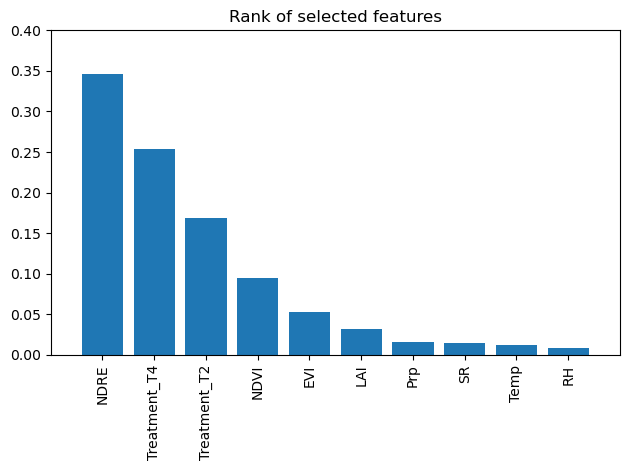

In [14]:
x_selected= x[['NDVI', 'NDRE', 'EVI', 'LAI', 'Prp', 'Temp', 'RH', 'SR', 'Treatment_T2', 'Treatment_T4']]

# ranks the selected features using the random forest (impurity) method
rf.fit(x_selected,y)
rf_importance= rf.feature_importances_
print(rf_importance)

# plots the importance of features in descending order for drone data
indices= np.argsort(rf_importance)[::-1]

plt.figure()
plt.title('Rank of selected features')
plt.bar(range(x_selected.shape[1]), rf_importance[indices])
plt.xticks(range(x_selected.shape[1]), x_selected.iloc[:,:].columns[indices], rotation= 90)
plt.xlim([-1, x_selected.shape[1]])
plt.ylim([0, 0.40])
plt.tight_layout()
plt.show

#### Further manually filtering the selected features was better because with minimum features, the scores did not change significantly (< 1). NDRE alone is way more accurate than NDVI alone for this project.
However, NDVI works better with the crop treatment column than NDRE with the treatment column.
NDRE and NDVI together yielded and r2 between 0.83 and 0.86.

In [16]:
#x_selected_real= x[['Red', 'Red_Edge', 'NIR', 'NDVI', 'Treatment_T2', 'Treatment_T4', 'Treatment_T1', 'Treatment_T3']]
#x_selected_without_random_state= x[['Red', 'NDVI', 'NDRE', 'EVI', 'LAI', 'Prp', 'RH', 'Treatment_T2', 'Treatment_T4', 'Treatment_T1', 'Treatment_T3']]
#x_selected_after_my_selection_without_bands= x[['NDVI', 'Treatment_T2', 'Treatment_T4', 'Treatment_T1', 'Treatment_T3']]
x_selected= x[['Blue', 'Green', 'Red', 'Red_Edge', 'NIR', 'NDVI', 'NDRE', 'NDWI', 'EVI', 'Treatment_T2', 'Treatment_T4']]

#Constant that multiplies the L1 (Lasso) or L2 (Ridge) term.
alphas = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

#trees for the random forest
#trees= [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

#for tree in trees:
for alpha in alphas:
    for trainIndex, testIndex in kf.split(x_selected):

        xTrain, xTest = x_selected.iloc[trainIndex], x_selected.iloc[testIndex]
        yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
        
        #rf= RandomForestRegressor(n_estimators=tree, random_state= 42).fit(xTrain, yTrain)
        #lr = Lasso(alpha=alpha).fit(xTrain, yTrain)
        lr = Ridge(alpha=alpha, random_state= 42).fit(xTrain, yTrain)
        
        #coefs[tree] = pd.DataFrame(lr.coef_)

        yPred = lr.predict(xTest)
        #score= rf.score(xTest, yTest)
        #print(score)
        
        # since it's in a loop, it only selects the last fold/run's value for each tree
        scores[alpha] = lr.score(xTest, yTest)
        
        # this appends all the scores of all folds of each tree to a list
        #all_scores.append(scores)
        
        RMSE[alpha] = np.sqrt(mean_squared_error(yPred, yTest))
        

In [17]:
df1 = pd.DataFrame(list(scores.items()), columns = ['alpha','R^2'])
df2 = pd.DataFrame(list(RMSE.items()), columns = ['alpha','RMSE'])
df3 = pd.merge(df1, df2, on= 'alpha')

In [18]:
df3

,alpha,R^2,RMSE
0,0.1,0.647609,19.437786
1,0.2,0.654534,19.245828
2,0.3,0.661882,19.040064
3,0.4,0.668876,18.842108
4,0.5,0.675473,18.653477
5,0.6,0.681690,18.473938
6,0.7,0.687550,18.303096
7,0.8,0.693073,18.140590
8,0.9,0.698279,17.986098
9,1.0,0.703183,17.839334


Text(0, 0.5, 'RMSE')

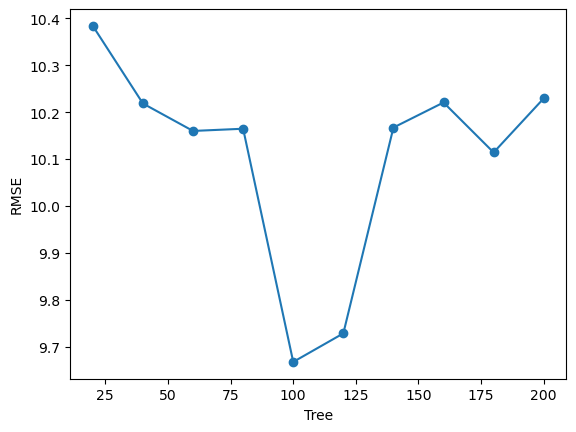

In [42]:
plt.plot(df3['tree'], df3['RMSE'], marker= 'o')
plt.xlabel('Tree')
plt.ylabel('RMSE')

In [15]:
# creates a dataframe for the predicted and actual crop yield
rf = RandomForestRegressor(random_state=42).fit(x_selected, y)
pred= lr.predict(x_selected)

pred_main= pd.DataFrame(list(zip(y, pred)), columns=['Actual', 'Predicted'])

In [16]:
# adds the predicted crop yield to the base data
gdf['Predicted']= pred_main['Predicted']

# residuals
gdf['Residual']= gdf['Yield'] - gdf['Predicted']

Text(0.5, 1.0, '2017 Predicted Yield')

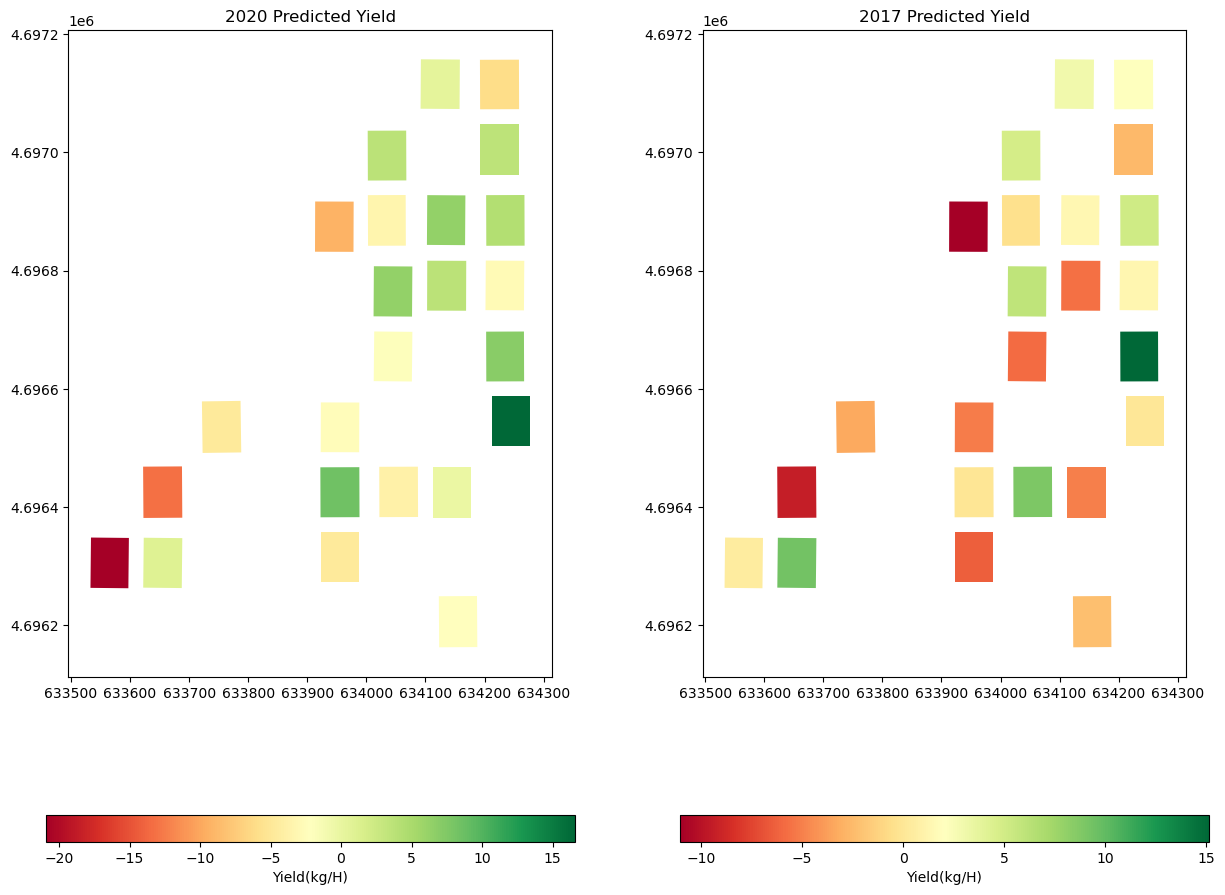

In [19]:
# plots the residual crop yield for 2020 and 2017
# splits data according to year
gdf_2020= gdf.iloc[0:24, :]
gdf_2017= gdf.iloc[24:, :]

# Creates 2 subplots
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(15, 12)) 
 
# Access each axes object to plot the data
gdf_2020.plot(column= 'Residual', ax= ax[0], legend= True, legend_kwds= {'label': 'Yield(kg/H)', 'orientation': 'horizontal'}, cmap='RdYlGn').set_title('2020 Predicted Yield')

gdf_2017.plot(column= 'Residual', ax= ax[1], legend= True, legend_kwds= {'label': 'Yield(kg/H)', 'orientation': 'horizontal'}, cmap='RdYlGn').set_title('2017 Predicted Yield')